In [560]:
from typing import TypeAlias
import math
import time
import json
import ctypes

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
!gcc -shared -o functions.so -fPIC -O3 functions.c

In [561]:
lib = ctypes.CDLL('./functions.so')

In [562]:
Sample: TypeAlias = list[int | float]
Samples: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [563]:
# Activation functions

def ReLU():
    return 0

def Sigmoid():
    return 1

def Softmax():
    return 2

def Empty():
    return 3

In [564]:
# Loss functions

def MSELoss():
    return 0

def CrossEntropy():
    return 1

In [565]:
class Dataset:
    def __init__(self, samples: Samples, targets: Targets) -> None:
        self.samples: Samples = np.array(samples)
        self._len = len(samples)
        self.targets: Targets = np.array(targets)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.samples[index], self.targets[index]

    def __iter__(self):
        return iter(zip(self.samples, self.targets))

In [566]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = []
        self.bias = []
        self.output = []

        if activation is None:
            self.activation = Empty()
        else:
            self.activation = activation

Layers = list[Linear]

In [567]:
class Model:
    def __init__(self, layers: Layers, loss: int, regression: bool = True, max_change: float = 0.1) -> None:
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
        self.regression = regression
        self.max_change = max_change

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True):
        dataset = [[sample, target] for sample, target in dataset]

        # Преобразуем данные для передачи в C
        array_samples = []
        array_targets = []
        for sample, target in dataset:
            arr = []
            for item in sample:
                arr.append(item)
            array_samples.append(arr)
            array_targets.append(target)
        # Конвертируем список в NumPy массив
        array_samples = np.array(array_samples, dtype=np.float64)
        array_targets = np.array(array_targets, dtype=np.float64)

        layer_sizes = []
        activations = []
        for layer in self.layers:
            layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        layer_sizes = np.array(layer_sizes)
        activations = np.array(activations, dtype=np.intc)

        # Описываем аргументы нашей функции
        lib.fit.argtypes = [
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_double,
            ctypes.c_int,
            ctypes.c_double,
        ]

        lib.fit(
            array_samples.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            array_targets.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(array_samples),
            len(array_samples[0]),
            len(array_samples[0][0]),
            len(array_targets),
            len(array_targets[0]),
            layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(layer_sizes),
            len(layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(activations),
            self.loss,
            n_epoch,
            learning_rate,
            verbose,
            self.max_change,
        )

        with open("weights.json", 'r') as file:
            weights = json.load(file)

        with open("biases.json", 'r') as file:
            biases = json.load(file)

        for i in range(len(self.layers)):
            self.layers[i].weights = np.array(weights[i])
            biases[i] = np.array(biases[i])
            self.layers[i].bias = np.array(biases[i], dtype=object)

    def predict(self, sample: Sample, predict_proba: bool = False) -> float:
        sample = np.array(sample)
        biases = np.array(self.layers[0].bias)
        weights = np.array(self.layers[0].weights)

        layer_size = [float(self.layers[0].n_inputs), float(self.layers[0].n_neurons)]
        layer_size = np.array(layer_size)
        activation = self.layers[0].activation
        prediction = np.zeros(self.layers[0].n_neurons)

        lib.predict.argtypes = [
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
        ]

        lib.predict(
            sample.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(sample),
            len(sample[0]),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(biases),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(weights),
            len(weights[0]),
            layer_size.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(layer_size),
            activation,
            prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        )

        self.layers[0].output = [prediction]

        for i in range(1, self._layers_len):
            sample = np.array(self.layers[i-1].output)
            biases = np.array(self.layers[i].bias)
            weights = np.array(self.layers[i].weights)

            layer_size = [float(self.layers[i].n_inputs), float(self.layers[i].n_neurons)]
            layer_size = np.array(layer_size)
            activation = self.layers[i].activation
            prediction = np.zeros(self.layers[i].n_neurons)

            lib.predict.argtypes = [
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
            ]

            lib.predict(
                sample.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(sample),
                len(sample[0]),
                biases.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(biases),
                weights.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(weights),
                len(weights[0]),
                layer_size.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(layer_size),
                activation,
                prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            )
            self.layers[i].output = [prediction]

        if predict_proba:
            return self.layers[-1].output
        else:
            if self.regression:
                return np.mean(self.layers[-1].output)
            else:
                return np.argmax(self.layers[-1].output)

    def set_weights(self, weights: Weights) -> None:
        for w, layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [568]:
X = sorted(np.random.uniform(0, 10, 10_000))
y = [[math.cos(x)] for x in X]

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [[X[i]]]

X_nested = np.array(X_nested)

X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

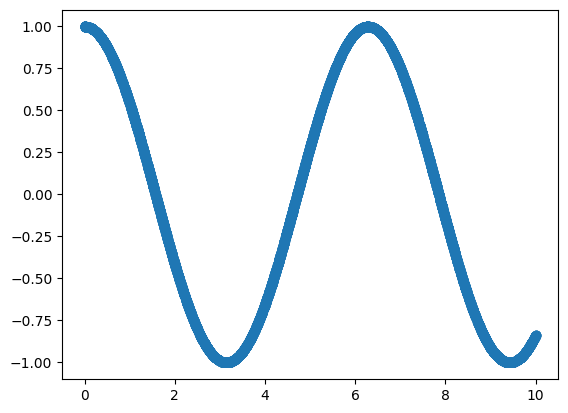

In [13]:
plt.plot(X, y, 'o')
plt.show()

Epoch 1 / 10. Loss: 636.764561
Epoch 2 / 10. Loss: 636.764561
Epoch 3 / 10. Loss: 636.764561
Epoch 4 / 10. Loss: 636.764561
Epoch 5 / 10. Loss: 636.764561
Epoch 6 / 10. Loss: 636.764561
Epoch 7 / 10. Loss: 636.764561
Epoch 8 / 10. Loss: 636.764561
Epoch 9 / 10. Loss: 636.764561
Epoch 10 / 10. Loss: 636.764561


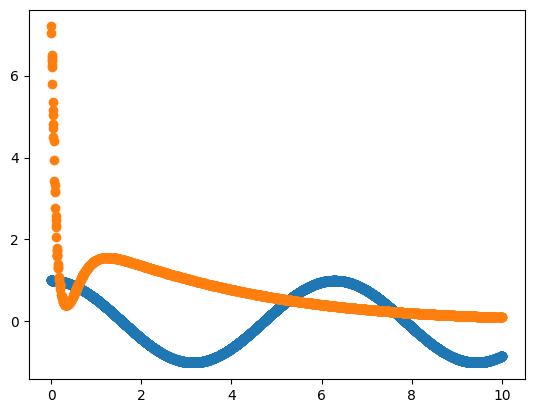

In [ ]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(1,10, activation=Sigmoid()),
    Linear(10,10, activation=Sigmoid()),
    Linear(10,1),
]

model = Model(layers=layers, loss=MSELoss(), regression=True, max_change=1000000000)
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.01, verbose=1)

preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

plt.plot(X_train.reshape(-1, 1), y_train, 'o')
plt.plot(X_val.reshape(-1, 1), preds, 'o')
plt.show()

# LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [16]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [17]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

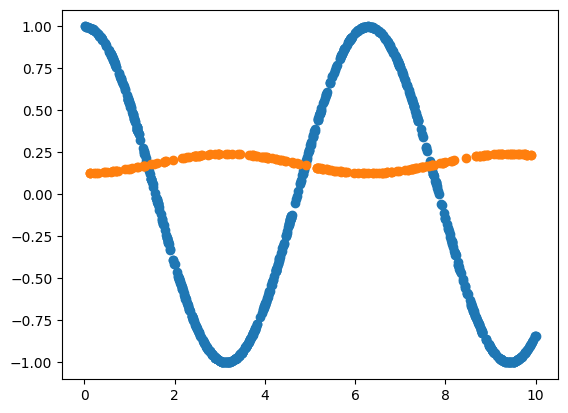

In [18]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [19]:
from sklearn.neural_network import MLPRegressor

In [20]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

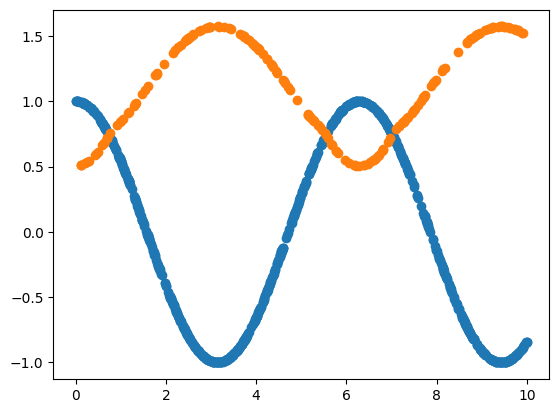

In [22]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# Make Moons dataset

In [24]:
from sklearn.datasets import make_moons

In [145]:
X, y = make_moons(n_samples=5000, noise=0.2)

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [X[i]]

y = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y[i] = np.array([1, 0])
    elif y[i] == 1:
        y[i] = np.array([0, 1])

y = np.array(y)

X_nested = np.array(X_nested)

In [146]:
X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

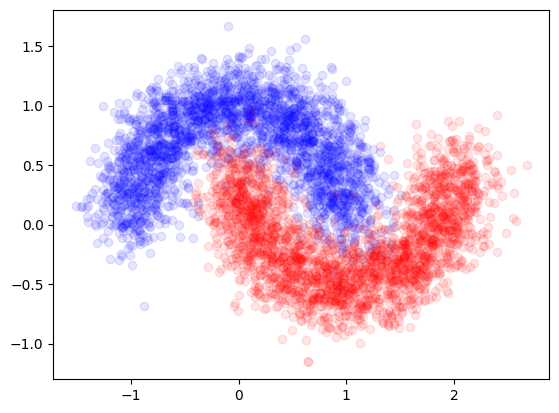

In [147]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])


plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.1)
plt.show()

In [ ]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(2,5, activation=Sigmoid()),
    Linear(5,5, activation=Sigmoid()),
    Linear(5,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=10000000)

model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.00001, verbose=1)

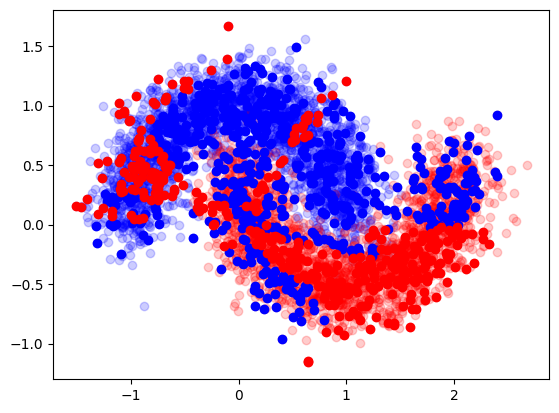

In [162]:
class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

for i in X_val:
    pred = model.predict(i)
    if pred == 0:
        class_1_X_test.append(i[0][0])
        class_1_y_test.append(i[0][1])
    elif pred == 1:
        class_2_X_test.append(i[0][0])
        class_2_y_test.append(i[0][1])


plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

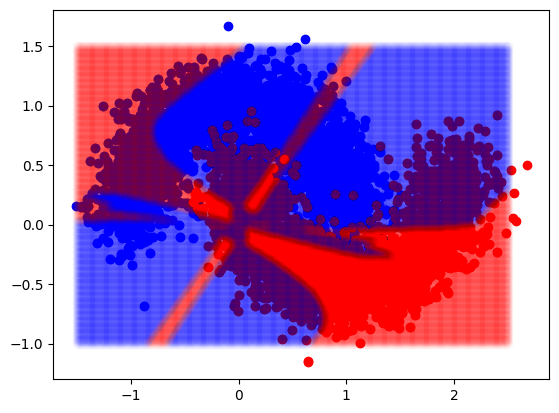

In [163]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])

class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
step = 0.01

# Создаем равномерную сетку узлов (X,Y)
xx, yy = np.meshgrid(np.arange(x_min, x_max + step, step),
                     np.arange(y_min, y_max + step, step))

points = np.c_[xx.ravel(), yy.ravel()]

for i in points:
    x = [i]
    pred = model.predict(x)
    if pred == 0:
        class_1_X_test.append(i[0])
        class_1_y_test.append(i[1])
    elif pred == 1:
        class_2_X_test.append(i[0])
        class_2_y_test.append(i[1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=1)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=0.01)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=0.01)
plt.show()

# MNIST dataset

In [574]:
from sklearn.datasets import load_digits

In [575]:
dataset = load_digits(n_class=2)

In [576]:
X, y = dataset.data, dataset.target

for i in range(len(X)):
    X[i] /= 255

X_reshaped = []
for i in range(len(X)):
    x = [X[i]]
    X_reshaped.append(x)

for i in range(len(X)):
    X[i] = np.array(X[i])

y_one_hot = np.zeros(len(y))
y_one_hot = list(y_one_hot)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

y_one_hot = np.array(y_one_hot)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

In [577]:
y_val = np.zeros(len(y_val_one_hot), dtype=int)

for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

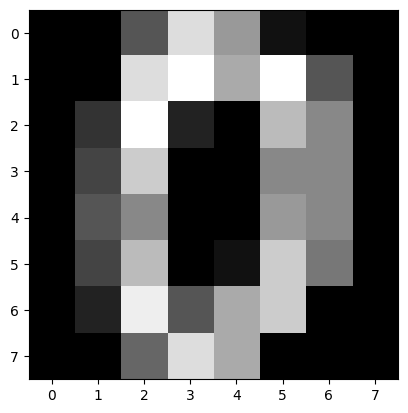

In [13]:
plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.show()

In [584]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Linear(8*8,5, activation=Sigmoid()),
    Linear(5,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=1)

model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.0000000001, verbose=True)

preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

accuracy_score(y_true=y_val, y_pred=preds) * 100

Epoch 1 / 1. Loss: -1.832731


97.22222222222221

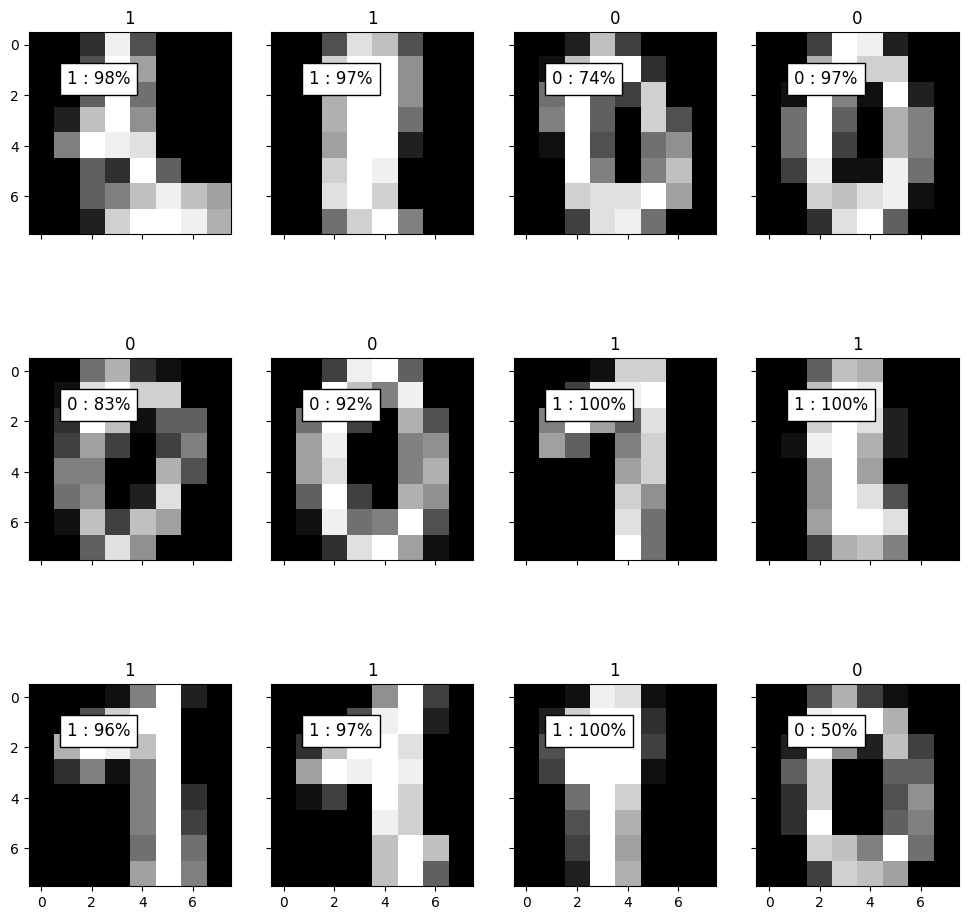

In [585]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(8,8), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val, title=label, plt_ax=fig_x)

    predicted_label = model.predict(im_val)

    prob_pred = model.predict(im_val, predict_proba=True)
    predicted_proba = np.max(prob_pred) * 100

    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top',fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))